In [6]:
import diff_gaussian_rasterization
import torch
import numpy as np
import pyquaternion
import os
import math
import matplotlib.pyplot as plt

In [7]:
device = torch.device("cuda")

# generate a random point cloud
N = 10
means3D = torch.cat(
    [
        torch.rand(N, 1, dtype=torch.float32, device=device) * 2 - 1,
        torch.rand(N, 1, dtype=torch.float32, device=device) * 2 - 1,
        torch.zeros(N, 1, dtype=torch.float32, device=device) + 5,
    ],
    dim=1,
)
means2D = torch.zeros(N, 2, dtype=torch.float32, device=device)
opacities = torch.ones(N, 1, dtype=torch.float32, device=device)
scales = torch.ones(N, 3, dtype=torch.float32, device=device)
rotations = (
    torch.from_numpy(np.stack([pyquaternion.Quaternion().elements for _ in range(N)]))
    .to(torch.float32)
    .to(device)
)
colors_precomp = torch.rand(N, 3, dtype=torch.float32, device=device)

In [8]:
means3D

tensor([[ 2.2618e-01,  7.8982e-01,  5.0000e+00],
        [-5.4496e-01,  7.2863e-01,  5.0000e+00],
        [ 9.1446e-01,  1.0289e-01,  5.0000e+00],
        [-1.2203e-01,  4.7322e-01,  5.0000e+00],
        [ 9.1146e-01, -4.7590e-03,  5.0000e+00],
        [ 3.5101e-01, -2.2582e-01,  5.0000e+00],
        [-3.0084e-01, -3.4123e-01,  5.0000e+00],
        [ 2.0726e-01, -6.6406e-01,  5.0000e+00],
        [ 4.6359e-01, -6.1342e-01,  5.0000e+00],
        [ 3.1468e-01, -2.9297e-01,  5.0000e+00]], device='cuda:0')

In [9]:
def gen_perspective_matrix(
    fovx: float, fovy: float, near: float, far: float
):
    """Generate perspective projection matrix.

    Args:
        fovx (float): field of view angle in degrees in the x direction
        fovy (float): field of view angle in degrees in the y direction
        near (float): near plane
        far (float): far plane

    Returns:
        torch.Tensor: perspective projection matrix
    """
    # Convert fov from degrees to radians and calculate the tangent
    tan_half_fovx = math.tan(math.radians(fovx / 2))
    tan_half_fovy = math.tan(math.radians(fovy / 2))

    return torch.tensor(
        [
            [1 / tan_half_fovx, 0, 0, 0],
            [0, 1 / tan_half_fovy, 0, 0],
            [0, 0, -(far + near) / (far - near), -2*(far * near) / (far - near)],
            [0, 0, -1, 0],
        ]
    )

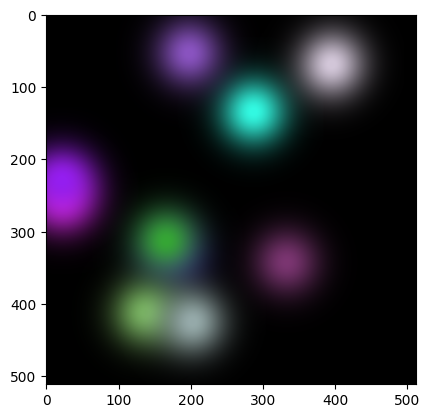

In [10]:
FoVx = 90
FoVy = 90

rasterizer = diff_gaussian_rasterization.GaussianRasterizer(
    diff_gaussian_rasterization.GaussianRasterizationSettings(
        image_height=512,
        image_width=512,
        tanfovx=math.tan(FoVx * 0.5),
        tanfovy=math.tan(FoVy * 0.5),
        bg=torch.zeros(4, dtype=torch.float32, device=device),
        scale_modifier=1.0,
        viewmatrix=torch.eye(4, dtype=torch.float32, device=device),
        projmatrix=gen_perspective_matrix(FoVx, FoVy, 0.1, 100).to(device),
        sh_degree=1,
        campos=torch.tensor([0, 0, 0], dtype=torch.float32, device=device),
        prefiltered=False,
        debug=True,
    )
)

rendered_image, radii = rasterizer(
    means3D=means3D,
    means2D=means2D,
    colors_precomp=colors_precomp,
    opacities=opacities,
    scales=scales,
    rotations=rotations,
)


# display the rendered image
plt.imshow(rendered_image.permute(1, 2, 0).cpu().numpy())